# Import Packages

In [1]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Algorithms 
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [2]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [3]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1 (CHECK)

In [4]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB (CHECK)

In [5]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling (CHECK)

In [6]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy (CHECK)

In [7]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [8]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB

In [9]:
def linucb(history, arms, context, alpha = 0.5):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        # context_arm = np.array(np.random.uniform(low = 0, high = 1, size = 2)) * context
        p_arm = theta.T @ context + alpha * np.sqrt(context.T @ A_inv @ context)
        scores[arm] = p_arm
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

### LinTS

In [10]:
def linTS(history, arms, context, v = 0.2):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        mu_tilde = np.random.multivariate_normal(container['mu_hat'][arm].flat, v**2 * np.linalg.inv(container['B'][arm]))[..., np.newaxis]
        # theta = 1/(1+np.exp(-1 * container['F'][arm]))
        theta = 1/(1+np.exp(-1 * container['B'][arm].dot(container['mu_hat'][arm])))
        scores[arm] = context.dot(mu_tilde)
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [11]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT),AGE_new,SEX_new
0,M,YOUNG,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,0.301196,0,1
1,F,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196,1,0
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0.419251,1,1
3,M,YOUNG,Y,L,N,N,Y,L,4,Alive,Alive and recovered,1,0.274168,0,1
4,M,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,M,YOUNG,N,L,N,N,N,L,2,Alive,Alive and recovered,1,0.274168,0,1
2496,F,YOUNG,N,L,N,N,Y,L,2,Alive,Alive and recovered,1,0.274168,0,0
2497,F,OLD,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,0.274168,1,0
2498,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0.419251,1,1


In [12]:
def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

get_reward_prob(logs_df)

[0.37824695127647184,
 0.320702714526284,
 0.3009344439309056,
 0.0001158902663385108]

In [13]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [14]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([1, 4, 3, 2], dtype=int64)

## Bernoulli Arm

In [15]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb, linTS]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation_ber = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 6:
                rec_a = f(container, arms)
            elif count_algos >= 8:
                # Context (for LinUCB) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                # context = np.array([np.random.uniform(low = 0, high = 1, size = 2) for _ in np.arange(len(arms))])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation_ber.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 8:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 9:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [16]:
evaluation_ber = pd.DataFrame(evaluation_ber)
evaluation_ber_policy = evaluation_ber.sort_values(by=['policy','time_step'])
evaluation_ber_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
16479,annealing_softmax,3,1,1,M,YOUNG,1,0
19368,annealing_softmax,4,1,2,M,OLD,1,0
21700,annealing_softmax,4,1,3,F,OLD,0,1
24971,annealing_softmax,3,1,4,M,OLD,1,0
28286,annealing_softmax,3,1,5,M,YOUNG,1,0
...,...,...,...,...,...,...,...,...
40086,ucb1,2,1802,5,F,OLD,0,1
40087,ucb1,2,1803,5,M,YOUNG,1,0
40088,ucb1,2,1804,5,F,OLD,0,1
40089,ucb1,2,1805,5,F,OLD,1,0


In [17]:
# evaluation[(evaluation["time_step"] == 1) | (evaluation["time_step"] == 2)]

In [18]:
final_evaluation_ber = evaluation_ber_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_ber['cumulative_reward'] = final_evaluation_ber.groupby(['policy'])['reward'].cumsum()
final_evaluation_ber['cumulative_regret'] = final_evaluation_ber.groupby(['policy'])['regret'].cumsum()
final_evaluation_ber

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.8,0.2,0.80,0.20
1,annealing_softmax,2,0.6,0.4,1.40,0.60
2,annealing_softmax,3,1.0,0.0,2.40,0.60
3,annealing_softmax,4,0.6,0.4,3.00,1.00
4,annealing_softmax,5,1.0,0.0,4.00,1.00
...,...,...,...,...,...,...
26428,ucb1,1802,0.0,1.0,1389.35,412.65
26429,ucb1,1803,1.0,0.0,1390.35,412.65
26430,ucb1,1804,0.0,1.0,1390.35,413.65
26431,ucb1,1805,1.0,0.0,1391.35,413.65


In [19]:
evaluation_ber_treatment = evaluation_ber.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_ber_treatment_F = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'F']
evaluation_ber_treatment_M = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'M']
evaluation_ber_treatment_Y = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'YOUNG']
evaluation_ber_treatment_O = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'OLD']

In [20]:
evaluation_ber_groupedtreatment_F = evaluation_ber_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [21]:
evaluation_ber_groupedtreatment_F = evaluation_ber_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.725675,0.274325
1,annealing_softmax,2,0.472930,0.527070
2,annealing_softmax,3,0.743438,0.256562
3,annealing_softmax,4,0.632289,0.367711
4,bayesian_ucb,1,0.500000,0.500000
5,bayesian_ucb,2,0.712957,0.287043
6,bayesian_ucb,4,0.922421,0.077579
7,epsilon_decay,1,0.592305,0.407695
8,epsilon_decay,2,0.517273,0.482727
9,epsilon_decay,3,0.662791,0.337209


In [22]:
evaluation_ber_groupedtreatment_M = evaluation_ber_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [23]:
evaluation_ber_groupedtreatment_M = evaluation_ber_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.708227,0.291773
1,annealing_softmax,2,0.761301,0.238699
2,annealing_softmax,3,0.808553,0.191447
3,annealing_softmax,4,0.796053,0.203947
4,bayesian_ucb,1,0.500000,0.500000
5,bayesian_ucb,2,0.821916,0.178084
6,bayesian_ucb,4,0.921348,0.078652
7,epsilon_decay,1,0.657268,0.342732
8,epsilon_decay,2,0.821668,0.178332
9,epsilon_decay,3,0.816929,0.183071


In [24]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [25]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.943444,0.056556
1,annealing_softmax,2,0.885538,0.114462
2,annealing_softmax,3,0.876324,0.123676
3,annealing_softmax,4,0.936567,0.063433
4,bayesian_ucb,1,1.000000,0.000000
5,bayesian_ucb,2,0.905314,0.094686
6,bayesian_ucb,4,0.970557,0.029443
7,epsilon_decay,1,0.826137,0.173863
8,epsilon_decay,2,0.902083,0.097917
9,epsilon_decay,3,0.873616,0.126384


In [26]:
evaluation_ber_groupedtreatment_O = evaluation_ber_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [27]:
evaluation_ber_groupedtreatment_O = evaluation_ber_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.614410,0.385590
1,annealing_softmax,2,0.428234,0.571766
2,annealing_softmax,3,0.722589,0.277411
3,annealing_softmax,4,0.545587,0.454413
4,bayesian_ucb,1,0.250000,0.750000
5,bayesian_ucb,2,0.734819,0.265181
6,bayesian_ucb,4,0.867229,0.132771
7,epsilon_decay,1,0.547862,0.452138
8,epsilon_decay,2,0.642959,0.357041
9,epsilon_decay,3,0.581725,0.418275


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [28]:
epsilon_greedy_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linucb']['reward'])
linTS_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linTS']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

F_onewayResult(statistic=3.5968919047117676, pvalue=0.0003489727828468891)

In [29]:
tukey_df_algo_ber = final_evaluation_ber[['policy', 'reward']]

tukey_algo_ber = pairwise_tukeyhsd(endog=tukey_df_algo_ber['reward'],
                                   groups=tukey_df_algo_ber['policy'],
                                   alpha=0.05)

In [30]:
print(tukey_algo_ber)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
annealing_softmax      bayesian_ucb  -0.0143 0.3809 -0.0341  0.0055  False
annealing_softmax     epsilon_decay    0.004 0.9982 -0.0126  0.0206  False
annealing_softmax    epsilon_greedy   0.0017    1.0 -0.0152  0.0186  False
annealing_softmax             linTS   0.0029 0.9998 -0.0137  0.0195  False
annealing_softmax            linucb    0.011 0.4933 -0.0055  0.0275  False
annealing_softmax           softmax  -0.0005    1.0 -0.0171   0.016  False
annealing_softmax thompson_sampling  -0.0128 0.3335 -0.0299  0.0044  False
annealing_softmax              ucb1  -0.0029    1.0 -0.0227  0.0169  False
     bayesian_ucb     epsilon_decay   0.0182 0.0985 -0.0015   0.038  False
     bayesian_ucb    epsilon_greedy    0.016  0.246 -0.0041   0.036  False
     bayesian_ucb        

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [31]:
evaluation_ber_groupedtreatment_F1 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_F2 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_F3 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_F4 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_M1 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_M2 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_M3 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_M4 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 4]

In [32]:
sex_1 = ttest_ind(evaluation_ber_groupedtreatment_F1['reward'], evaluation_ber_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_ber_groupedtreatment_F2['reward'], evaluation_ber_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_ber_groupedtreatment_F3['reward'], evaluation_ber_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_ber_groupedtreatment_F4['reward'], evaluation_ber_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=0.9056446858121739, pvalue=0.37856020300940096)
Treatment 2 (sex): Ttest_indResult(statistic=-2.54875718591442, pvalue=0.022252726754069013)
Treatment 3 (sex): Ttest_indResult(statistic=-0.6436272627087293, pvalue=0.530220053055914)
Treatment 4 (sex): Ttest_indResult(statistic=-1.2899389820475045, pvalue=0.2179730607497524)


In [33]:
evaluation_ber_groupedtreatment_Y1 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_Y2 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_Y3 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_Y4 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_O1 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_O2 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_O3 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_O4 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 4]

In [34]:
age_1 = ttest_ind(evaluation_ber_groupedtreatment_Y1['reward'], evaluation_ber_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_ber_groupedtreatment_Y2['reward'], evaluation_ber_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_ber_groupedtreatment_Y3['reward'], evaluation_ber_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_ber_groupedtreatment_Y4['reward'], evaluation_ber_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=7.188682930619784, pvalue=2.1571878022747104e-06)
Treatment 2 (age): Ttest_indResult(statistic=7.224750989363006, pvalue=2.027024269184602e-06)
Treatment 3 (age): Ttest_indResult(statistic=3.1053105391025824, pvalue=0.008360862850245777)
Treatment 4 (age): Ttest_indResult(statistic=2.4240187464337097, pvalue=0.0320811398217917)


## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

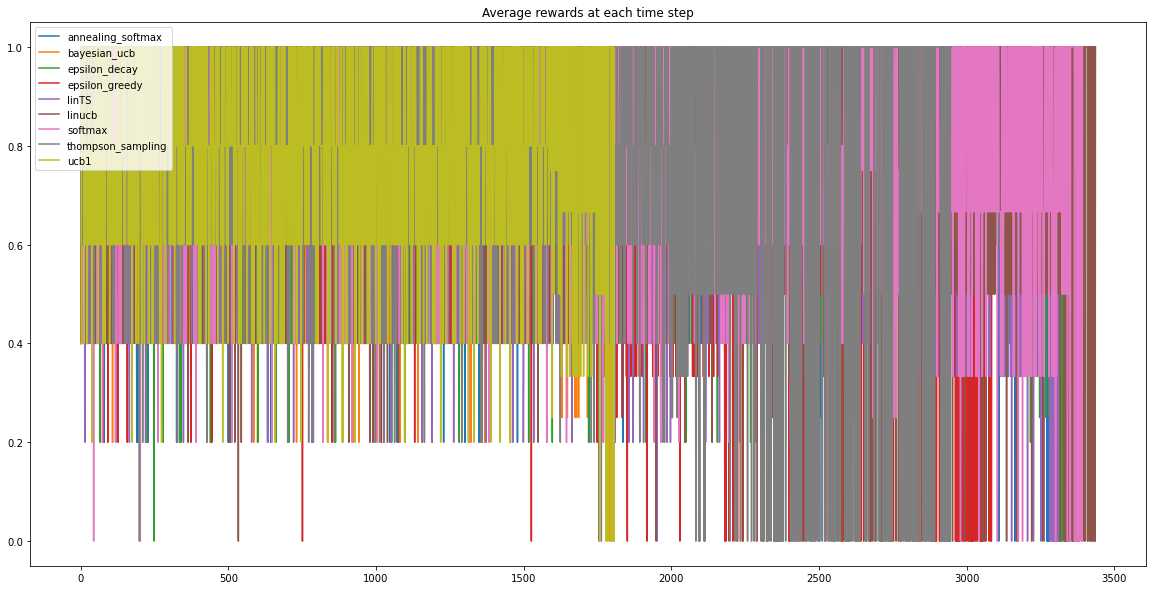

In [35]:
# Plot the rewards at each time step
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))

plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [36]:
# Determine the cumulative reward at 1000 time step
final_evaluation_ber.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,2563.433333
1,bayesian_ucb,1369.233333
2,epsilon_decay,2584.350000
3,epsilon_greedy,2393.900000
4,linTS,2576.183333
5,linucb,2694.800000
6,softmax,2621.200000
7,thompson_sampling,2241.200000
8,ucb1,1391.350000


Text(0.5, 1.0, 'Cumulative rewards at each step')

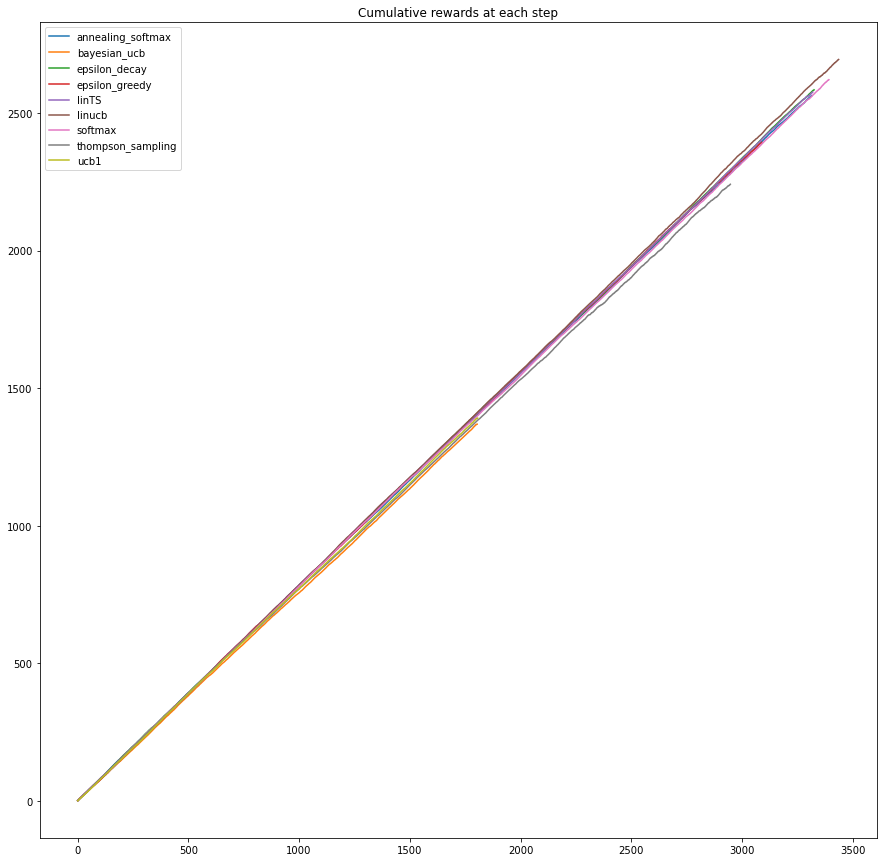

In [37]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

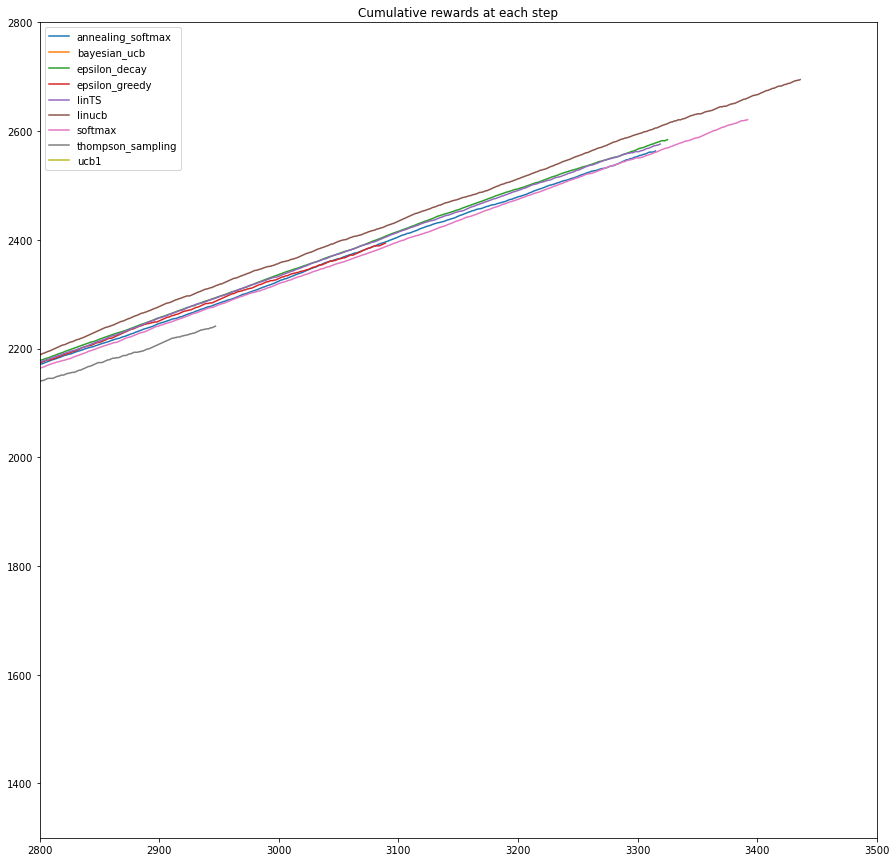

In [38]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.xlim(2800, 3500)
plt.ylim(1300, 2800)
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [39]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation_cat = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'mean', 'count', 'cat_dict']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'mean': 'float', 'count': 'float'})
        
        # To keep track of categories count
        categories_dict = {'Dead': 0, 'Alive and still dependent': 0, 'Alive and recovered': 0, 'Alive with unknown status': 0}
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, categories_dict]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 4:
                rec_a = f(container, arms)
            elif count_algos == 4:
                rec_a = f(container, arms, 0.2)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 1 - reward
                category = bsample.iloc[i - 1]['REWARD_CATEGORICAL']
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm': action, 'time_step': step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward': reward, 'regret': regret}
                evaluation_cat.append(eva_rec)
                
                # Update reward category
                container['cat_dict'][action - 1][category] = container['cat_dict'][action - 1][category] + 1
                new_estimated_prob = container['cat_dict'][action - 1]['Alive and still dependent'] / sum(container['cat_dict'][action - 1].values())

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['mean'] = np.where(container['arm'] == action, new_estimated_prob, container['mean'])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [40]:
evaluation_cat = pd.DataFrame(evaluation_cat)
evaluation_cat_policy = evaluation_cat.sort_values(by=['policy','time_step'])
evaluation_cat_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
13819,annealing_softmax,3,1,1,F,YOUNG,0.274168,0.725832
16353,annealing_softmax,3,1,2,M,YOUNG,0.301196,0.698804
18894,annealing_softmax,3,1,3,M,YOUNG,0.419251,0.580749
21354,annealing_softmax,3,1,4,M,OLD,0.419251,0.580749
23866,annealing_softmax,3,1,5,M,OLD,0.301196,0.698804
...,...,...,...,...,...,...,...,...
34944,ucb1,2,1799,5,F,OLD,0.419251,0.580749
34945,ucb1,2,1800,5,M,YOUNG,0.301196,0.698804
34946,ucb1,2,1801,5,F,OLD,0.419251,0.580749
34947,ucb1,2,1802,5,F,OLD,0.274168,0.725832


In [41]:
final_evaluation_cat = evaluation_cat_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_cat['cumulative_reward'] = final_evaluation_cat.groupby(['policy'])['reward'].cumsum()
final_evaluation_cat['cumulative_regret'] = final_evaluation_cat.groupby(['policy'])['regret'].cumsum()
final_evaluation_cat

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.343012,0.656988,0.343012,0.656988
1,annealing_softmax,2,0.295790,0.704210,0.638803,1.361197
2,annealing_softmax,3,0.319401,0.680599,0.958204,2.041796
3,annealing_softmax,4,0.295790,0.704210,1.253995,2.746005
4,annealing_softmax,5,0.313996,0.686004,1.567990,3.432010
...,...,...,...,...,...,...
12766,ucb1,1799,0.419251,0.580749,570.360499,1228.639501
12767,ucb1,1800,0.301196,0.698804,570.661695,1229.338305
12768,ucb1,1801,0.419251,0.580749,571.080946,1229.919054
12769,ucb1,1802,0.274168,0.725832,571.355114,1230.644886


In [42]:
evaluation_cat_treatment = evaluation_cat.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_cat_treatment_F = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'F']
evaluation_cat_treatment_M = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'M']
evaluation_cat_treatment_Y = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'YOUNG']
evaluation_cat_treatment_O = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'OLD']

In [43]:
evaluation_cat_groupedtreatment_F = evaluation_cat_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [44]:
evaluation_cat_groupedtreatment_F = evaluation_cat_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.321504,0.678496
1,annealing_softmax,2,0.329376,0.670624
2,annealing_softmax,3,0.319709,0.680291
3,annealing_softmax,4,0.320992,0.679008
4,epsilon_decay,1,0.322205,0.677795
5,epsilon_decay,2,0.335476,0.664524
6,epsilon_decay,3,0.318034,0.681966
7,epsilon_decay,4,0.327683,0.672317
8,epsilon_greedy,1,0.321297,0.678703
9,epsilon_greedy,2,0.327212,0.672788


In [45]:
evaluation_cat_groupedtreatment_M = evaluation_cat_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [46]:
evaluation_cat_groupedtreatment_M = evaluation_cat_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.313640,0.686360
1,annealing_softmax,2,0.314494,0.685506
2,annealing_softmax,3,0.309753,0.690247
3,annealing_softmax,4,0.298929,0.701071
4,epsilon_decay,1,0.314455,0.685545
5,epsilon_decay,2,0.312134,0.687866
6,epsilon_decay,3,0.308502,0.691498
7,epsilon_decay,4,0.297412,0.702588
8,epsilon_greedy,1,0.312907,0.687093
9,epsilon_greedy,2,0.317323,0.682677


In [47]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [48]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.293116,0.706884
1,annealing_softmax,2,0.296939,0.703061
2,annealing_softmax,3,0.299044,0.700956
3,annealing_softmax,4,0.291677,0.708323
4,epsilon_decay,1,0.294308,0.705692
5,epsilon_decay,2,0.294203,0.705797
6,epsilon_decay,3,0.295161,0.704839
7,epsilon_decay,4,0.292017,0.707983
8,epsilon_greedy,1,0.293808,0.706192
9,epsilon_greedy,2,0.297128,0.702872


In [49]:
evaluation_cat_groupedtreatment_O = evaluation_cat_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [50]:
evaluation_cat_groupedtreatment_O = evaluation_cat_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.332925,0.667075
1,annealing_softmax,2,0.332579,0.667421
2,annealing_softmax,3,0.323216,0.676784
3,annealing_softmax,4,0.321866,0.678134
4,epsilon_decay,1,0.333691,0.666309
5,epsilon_decay,2,0.335011,0.664989
6,epsilon_decay,3,0.323498,0.676502
7,epsilon_decay,4,0.324373,0.675627
8,epsilon_greedy,1,0.331676,0.668324
9,epsilon_greedy,2,0.334303,0.665697


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [51]:
epsilon_greedy_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'ucb1']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards)

F_onewayResult(statistic=10410.51579446696, pvalue=0.0)

In [52]:
tukey_df_algo_cat = final_evaluation_cat[['policy', 'reward']]

tukey_algo_cat = pairwise_tukeyhsd(endog=tukey_df_algo_cat['reward'],
                                   groups=tukey_df_algo_cat['policy'],
                                   alpha=0.05)

In [53]:
print(tukey_algo_cat)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------
annealing_softmax  epsilon_decay     -0.0    1.0 -0.0022 0.0021  False
annealing_softmax epsilon_greedy   0.0009 0.7888 -0.0013 0.0032  False
annealing_softmax        softmax   0.0006   0.95 -0.0016 0.0028  False
annealing_softmax           ucb1   0.0014 0.5703 -0.0011 0.0038  False
    epsilon_decay epsilon_greedy    0.001 0.7316 -0.0012 0.0031  False
    epsilon_decay        softmax   0.0006 0.9286 -0.0015 0.0027  False
    epsilon_decay           ucb1   0.0014 0.5042  -0.001 0.0038  False
   epsilon_greedy        softmax  -0.0003 0.9938 -0.0026 0.0019  False
   epsilon_greedy           ucb1   0.0004 0.9911 -0.0021 0.0029  False
          softmax           ucb1   0.0008  0.919 -0.0017 0.0032  False
----------------------------------------------------------------------


### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [54]:
evaluation_cat_groupedtreatment_F1 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_F2 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_F3 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_F4 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_M1 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_M2 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_M3 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_M4 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 4]

In [55]:
sex_1 = ttest_ind(evaluation_cat_groupedtreatment_F1['reward'], evaluation_cat_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_cat_groupedtreatment_F2['reward'], evaluation_cat_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_cat_groupedtreatment_F3['reward'], evaluation_cat_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_cat_groupedtreatment_F4['reward'], evaluation_cat_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=0.3614347955628497, pvalue=0.7271340145982544)
Treatment 2 (sex): Ttest_indResult(statistic=5.714084946715806, pvalue=0.00044706647340180054)
Treatment 3 (sex): Ttest_indResult(statistic=1.0041114567401148, pvalue=0.34472575596225696)
Treatment 4 (sex): Ttest_indResult(statistic=1.83483792093671, pvalue=0.10386414966401471)


In [56]:
evaluation_cat_groupedtreatment_Y1 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_Y2 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_Y3 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_Y4 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_O1 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_O2 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_O3 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_O4 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 4]

In [57]:
age_1 = ttest_ind(evaluation_cat_groupedtreatment_Y1['reward'], evaluation_cat_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_cat_groupedtreatment_Y2['reward'], evaluation_cat_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_cat_groupedtreatment_Y3['reward'], evaluation_cat_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_cat_groupedtreatment_Y4['reward'], evaluation_cat_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=-6.293217915436855, pvalue=0.00023449512198811683)
Treatment 2 (age): Ttest_indResult(statistic=-10.19923032700153, pvalue=7.324330444350879e-06)
Treatment 3 (age): Ttest_indResult(statistic=-2.7464649765241496, pvalue=0.025196190818188562)
Treatment 4 (age): Ttest_indResult(statistic=-2.181521948256299, pvalue=0.06071823390491239)


## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

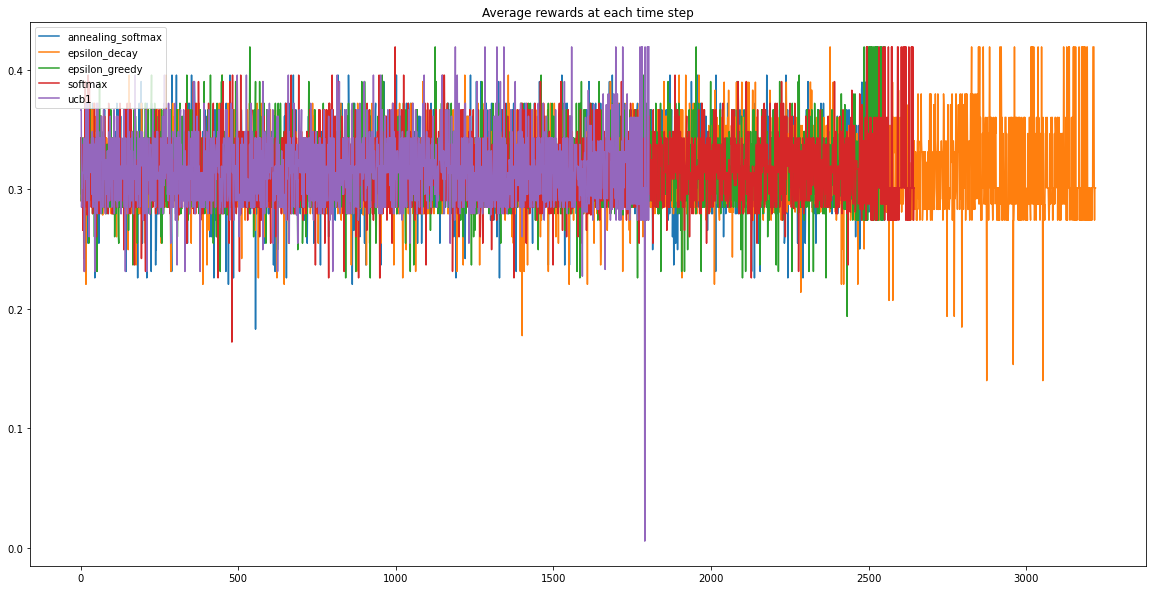

In [58]:
# Plot the rewards at each time step
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [59]:
# Determine the cumulative reward at 1000 time step
final_evaluation_cat.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,805.524121
1,epsilon_decay,1016.680718
2,epsilon_greedy,808.238268
3,softmax,836.789178
4,ucb1,571.774365


Text(0.5, 1.0, 'Cumulative rewards at each step')

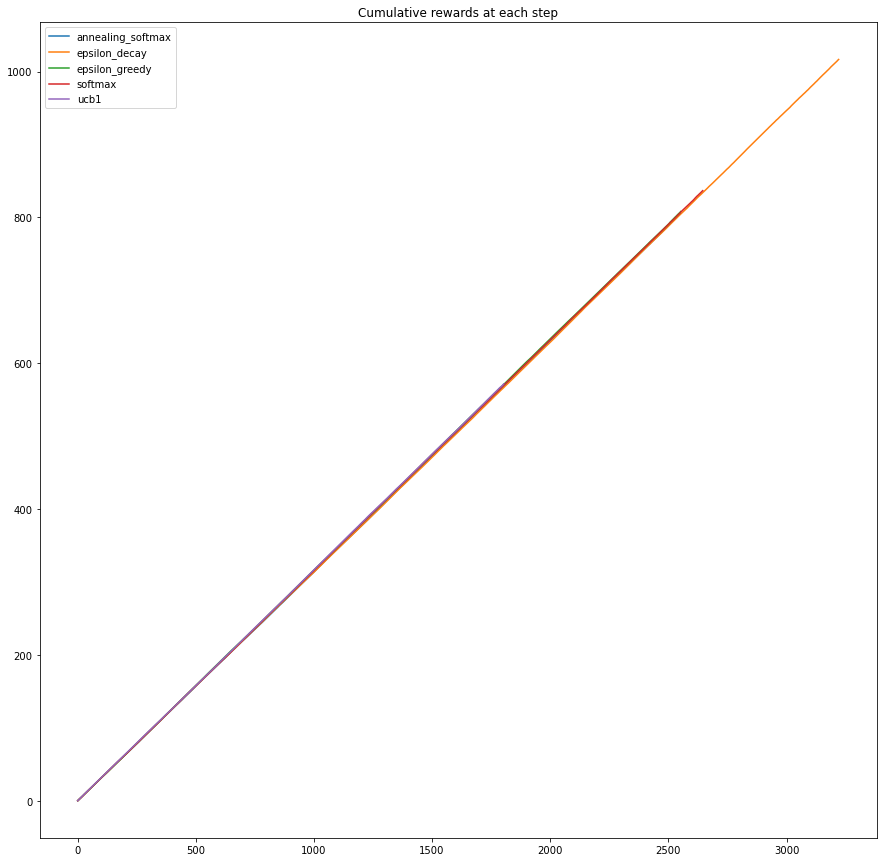

In [60]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

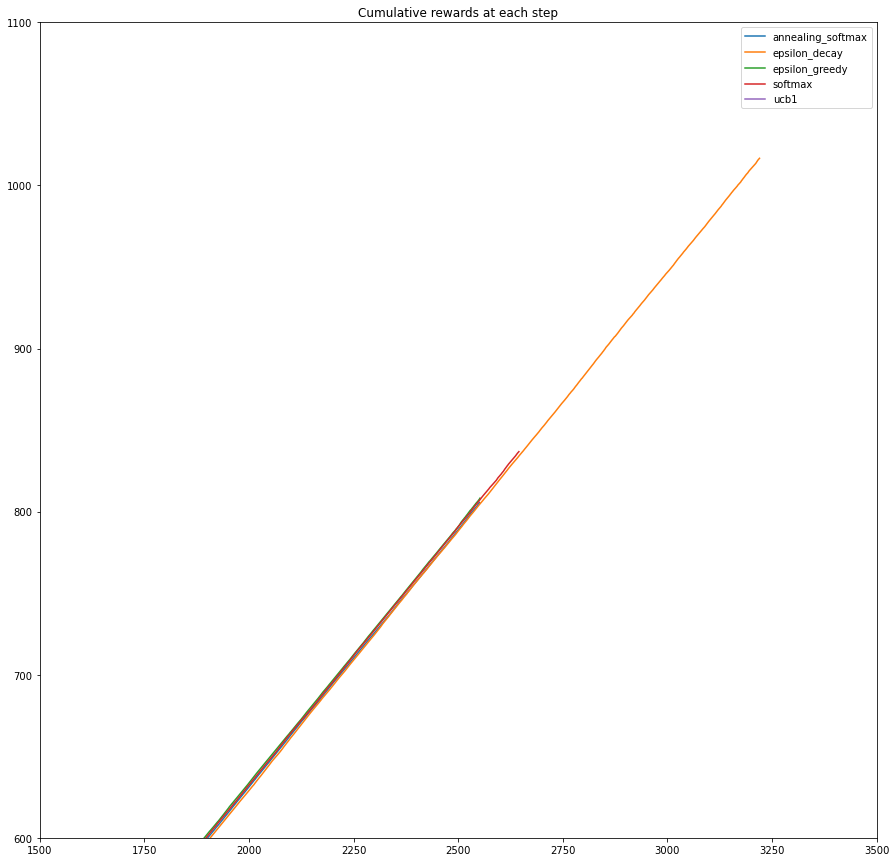

In [61]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
    
plt.xlim(1500, 3500)
plt.ylim(600, 1100)
plt.legend()
plt.title("Cumulative rewards at each step")